In [1171]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, root_mean_squared_error

plt.style.use('ggplot')

### Goal
- Develop a real estate pricing model that predicts house prices based on various features.
- Create an API that outputs the predicted price when given the features.

### Data Validation
- Was given three datasets: 'economics.csv', 'property_data.csv', and 'transactions.csv'. After merging the datasets, I had the following columns:
- **Property ID**: Numeric, unique identifier of the property sold.
- **Transaction Date**: Datetime, transaction date
- **Property Type**: Character, type of property. Categorize the property into: 'condo', 'apartment', 'house', and 'townhouse'.
- **Sale Price**: Numeric, price that the property was sold.
- **Purchase Price**: Numeric, price that the property was bought.
- **Comission Rate**: Numeric, comission that the agent charged for the transaction
- **Profit**: Numeric, difference between sale price and purchase price
- **Location**: Character, location name (Street)
- **Size sqft**: Numeric, square feet size of the property
- **Bedrooms**: Numeric, number of bedrooms.
- **Property Size**: Numeric, size of the property
- **Year Built**: Numeric, year in that the build was constructed.
- **Listing Price**: Numeric, price that the property was anouced.
- **Neighborhood**: Character, property neighborhood.
- **Garage Spaces**: Numeric, number of garage spaces
- **Has Pool**: Boolean, if the property has pool or not.


#### Data Problem
Since we want to predict the house prices, we are dealing with a **regression problem**. I will predict the **Sale Price** column.


#### Data Changes
- Droped some columns without enough variance.
- Change data type for date columns.
- Droped columns that could lead to leakeage, like the profit.

In [1172]:
economics = pd.read_csv('Data/economics.csv')
transactions = pd.read_csv('Data/transactions.csv')
property = pd.read_csv('Data/property_data.csv')

#### Economics
- This dataset contains economics indicators, containing 1000 rows and 29 columns.
- It only contains numerical values.
- There aren't missing values.
- The dataset don't present outliers.
-
- **I couldn't find any column that relate this dataset to the others and there is no time stamp column.**
- **I recommend to explore the source of this data to include the time stamp, so we can link this dataset to the others.**

In [1173]:
#Check for data type and missing values
economics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   interest_rate                    1000 non-null   float64
 1   unemployment_rate                1000 non-null   float64
 2   inflation_rate                   1000 non-null   float64
 3   gdp_growth_rate                  1000 non-null   float64
 4   labor_force_participation_rate   1000 non-null   float64
 5   consumer_confidence_index        1000 non-null   float64
 6   government_debt_to_gdp_ratio     1000 non-null   float64
 7   exchange_rate                    1000 non-null   float64
 8   stock_market_index               1000 non-null   float64
 9   housing_price_index              1000 non-null   float64
 10  manufacturing_pmi                1000 non-null   float64
 11  services_pmi                     1000 non-null   float64
 12  retail_sales_growth_r

In [1174]:
#Check for outliers in economics
economics.describe()

,interest_rate,unemployment_rate,inflation_rate,gdp_growth_rate,labor_force_participation_rate,consumer_confidence_index,government_debt_to_gdp_ratio,exchange_rate,stock_market_index,housing_price_index,...,business_startups_rate,consumer_spending,investment_rate,savings_rate,tax_revenue,interest_coverage_ratio,bankruptcies_rate,business_closures_rate,consumer_debt_to_income_ratio,government_deficit_to_gdp_ratio
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,5.09107,10.194420,0.028130,-0.112480,51.37444,99.34441,101.817990,1.522520,25149.785260,272.993190,...,49.462030,496943.352770,49.210700,49.428900,5.014713e+07,50.89443,5.072960,5.066430,245.593610,5.096980
std,2.80546,5.687702,2.861397,5.713069,29.48179,56.14199,58.087382,0.855760,14634.920801,133.009378,...,29.178894,289123.488684,28.538652,29.015521,2.917962e+07,29.38848,2.933028,2.856688,146.879964,2.915088
min,0.00000,0.020000,-4.990000,-9.980000,0.06000,0.05000,0.150000,0.005900,13.370000,50.130000,...,0.070000,565.310000,0.010000,0.120000,1.413380e+05,0.14000,0.010000,0.050000,0.410000,0.010000
25%,2.84750,5.355000,-2.482500,-5.020000,25.18500,51.43750,51.510000,0.847225,12428.930000,157.015000,...,23.647500,245601.067500,23.275000,23.522500,2.539032e+07,25.17250,2.647500,2.692500,112.082500,2.640000
50%,5.17000,10.485000,0.185000,-0.295000,52.80500,99.56000,100.990000,1.504700,25787.745000,271.950000,...,50.370000,501958.465000,50.100000,49.845000,4.944122e+07,50.69500,5.155000,5.105000,253.260000,5.195000
75%,7.44250,15.155000,2.442500,4.700000,76.68000,145.05750,152.450000,2.263350,37547.280000,387.502500,...,74.667500,733707.425000,74.010000,75.075000,7.625037e+07,76.92000,7.512500,7.520000,371.207500,7.625000
max,10.00000,19.970000,4.990000,9.950000,99.90000,199.96000,199.600000,2.998800,49977.020000,499.280000,...,99.830000,999429.530000,99.970000,99.980000,9.996664e+07,99.96000,10.000000,9.990000,497.060000,10.000000


### Transactions
- This dataset contains transactions history, containing 1000 rows and 10 columns
- 'transaction_date' column was in wrong format and was converted.
- 'buyer_name', 'seller_name', and 'agent_name' don't have enough variance in their categories, an unique person doesn't repeat between rows.
- The dataset doesn't present outliers

#### Data description

- **Property ID**: Numeric, unique identifier of the property sold.
- **Transaction Date**: Datetime, transaction date
- **Property Type**: Character, type of property. Categorize the property into: 'condo', 'apartment', 'house', and 'townhouse'.
- **Sale Price**: Numeric, price that the property was sold.
- **Purchase Price**: Numeric, price that the property was bought.
- **Comission Rate**: Numeric, comission that the agent charged for the transaction

In [1175]:
#Check for data type and missing values
print(transactions.info())
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   property_id       1000 non-null   int64  
 1   transaction_date  1000 non-null   object 
 2   property_type     1000 non-null   object 
 3   sale_price        1000 non-null   float64
 4   purchase_price    1000 non-null   float64
 5   buyer_name        1000 non-null   object 
 6   seller_name       1000 non-null   object 
 7   agent_name        1000 non-null   object 
 8   commission_rate   1000 non-null   float64
 9   profit            1000 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 78.3+ KB
None


In [1176]:
#Check for property type variance and unique values
print(transactions.groupby('property_type').size().sort_values(ascending=False))
transactions['property_type'].unique()

property_type
condo        259
house        259
apartment    245
townhouse    237
dtype: int64


array(['condo', 'apartment', 'house', 'townhouse'], dtype=object)

In [1177]:
#Check for buyer_name variance and unique values
transactions.groupby('buyer_name').size().sort_values(ascending=False).head(5)

buyer_name
Zolly Eagle      1
Abbey Poon       1
Abdel Bucklee    1
Abel Buterton    1
Abel Speight     1
dtype: int64

In [1178]:
#Check for seller_name variance and unique values
transactions.groupby('seller_name').size().sort_values(ascending=False).head(5)

seller_name
Zonnya McGahey      1
Abbie Giacobelli    1
Abbott Kleinfeld    1
Abigail Welham      1
Ade Coote           1
dtype: int64

In [1179]:
#Check for agent_name variance and unique values
transactions.groupby('agent_name').size().sort_values(ascending=False).head(5)

agent_name
Zorine Hasney       1
Abagail Willwood    1
Abbe Laurenty       1
Abbie Lorain        1
Abner Glasard       1
dtype: int64

In [1180]:
#Dropping columns without variance or leakeage
transactions = transactions.drop(['buyer_name', 'seller_name', 'agent_name', 'profit', 'commission_rate'], axis=1)

In [1181]:
#Check for outliers
transactions.describe()

,property_id,transaction_date,sale_price,purchase_price
count,1000.000000,1000,1000.000000,1000.000000
mean,500.500000,2020-12-22 03:51:50.400000,527628.918960,528515.232120
min,1.000000,2020-01-01 00:00:00,51745.340000,51704.270000
25%,250.750000,2020-06-24 00:00:00,289499.695000,290190.015000
50%,500.500000,2020-12-21 00:00:00,520343.345000,534299.390000
75%,750.250000,2021-06-18 00:00:00,756956.712500,774404.957500
max,1000.000000,2021-12-29 00:00:00,999774.430000,998700.150000
std,288.819436,NaN,273770.592932,278594.847411


### Property
- This dataset contains property proprieties, containing 1000 rows and 15 columns
- 'property_id' and 'id' have the same values. I droped 'id'.
- 'location' has low variance. We have 1000 rows and 437 location types. The most frequent location has 8 observations. It's recommended to group these location by a more macro region.
- 'year_built' was in the wrong format, I conveted it to datetime.
- 'bedrooms' and 'num_bedrooms' have the same meaning. I droped 'num_bedrooms'
- 'num_bathrooms' was in the wrong format. I decided to drop this column, since we have the same information in 'bathroom' column.
- Since I found inconsistency into 'property' dataset and we have 'property_type' in both, property dataset and transaction dataset, I droped property_type in property dataset.

#### Data description

- **Location**: Character, location name (Street)
- **Size sqft**: Numeric, square feet size of the property
- **Bedrooms**: Numeric, number of bedrooms.
- **Property ID**: Numeric, unique identifier of the property.
- **Property Size**: Numeric, size of the property
- **Year Built**: Numeric, year in that the build was constructed.
- **Listing Price**: Numeric, price that the property was anouced.
- **Neighborhood**: Character, property neighborhood.
- **Garage Spaces**: Numeric, number of garage spaces
- **Has Pool**: Boolean, if the property has pool or not.

In [1182]:
print(property.info())
property['year_built'] = pd.to_datetime(property['year_built'], format='%Y')
property = property.drop(['num_bathrooms', 'num_bedrooms', 'property_type'], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1000 non-null   int64  
 1   location       1000 non-null   object 
 2   size_sqft      1000 non-null   int64  
 3   bedrooms       1000 non-null   int64  
 4   bathrooms      1000 non-null   int64  
 5   property_id    1000 non-null   int64  
 6   property_type  1000 non-null   object 
 7   property_size  1000 non-null   int64  
 8   year_built     1000 non-null   int64  
 9   listing_price  1000 non-null   float64
 10  num_bedrooms   1000 non-null   int64  
 11  num_bathrooms  1000 non-null   float64
 12  neighborhood   1000 non-null   object 
 13  garage_spaces  1000 non-null   int64  
 14  has_pool       1000 non-null   bool   
dtypes: bool(1), float64(2), int64(9), object(3)
memory usage: 110.5+ KB
None


In [1183]:
#Check for property id and property_id. Both have the same values, we can drop one of those columns
(property['id'] - property['property_id']).value_counts()
property = property.drop('id', axis=1)

In [1184]:
#Check for location variance and unique values
property.groupby('location').size().sort_values(ascending=False)
property = property.drop('location', axis=1)

In [1185]:
#Check for neighborhood variance and unique values
property.groupby('neighborhood').size().sort_values(ascending=False)

neighborhood
rural       352
suburban    327
urban       321
dtype: int64

In [1186]:
#Check garage_spaces
property['garage_spaces'].value_counts()

garage_spaces
0    264
2    254
1    253
3    229
Name: count, dtype: int64

In [1187]:
property['bedrooms'].value_counts()

bedrooms
4    221
1    211
3    199
2    192
5    177
Name: count, dtype: int64

In [1188]:
property['bathrooms'].value_counts()

bathrooms
4    179
1    170
3    168
5    168
6    162
2    153
Name: count, dtype: int64

In [1189]:
#Check for numerical values
property.describe()

,size_sqft,bedrooms,bathrooms,property_id,property_size,year_built,listing_price,garage_spaces
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000,1000.000000,1000.000000
mean,501.028000,2.961000,3.508000,500.500000,2760.230000,1962-10-22 15:21:36,544311.871870,1.448000
min,1.000000,1.000000,1.000000,1.000000,505.000000,1900-01-01 00:00:00,100358.270000,0.000000
25%,260.750000,2.000000,2.000000,250.750000,1579.500000,1933-10-01 18:00:00,320294.705000,0.000000
50%,480.500000,3.000000,4.000000,500.500000,2792.500000,1963-01-01 00:00:00,537369.045000,1.000000
75%,750.000000,4.000000,5.000000,750.250000,3944.000000,1994-04-02 06:00:00,764595.350000,2.000000
max,1000.000000,5.000000,6.000000,1000.000000,4993.000000,2022-01-01 00:00:00,999759.420000,3.000000
std,287.186088,1.401943,1.699065,288.819436,1319.579978,NaN,258375.306032,1.111094


In [1190]:
df = transactions.merge(property, how='outer', on='property_id')
df.set_index('property_id', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_date  1000 non-null   datetime64[ns]
 1   property_type     1000 non-null   object        
 2   sale_price        1000 non-null   float64       
 3   purchase_price    1000 non-null   float64       
 4   size_sqft         1000 non-null   int64         
 5   bedrooms          1000 non-null   int64         
 6   bathrooms         1000 non-null   int64         
 7   property_size     1000 non-null   int64         
 8   year_built        1000 non-null   datetime64[ns]
 9   listing_price     1000 non-null   float64       
 10  neighborhood      1000 non-null   object        
 11  garage_spaces     1000 non-null   int64         
 12  has_pool          1000 non-null   bool          
dtypes: bool(1), datetime64[ns](2), float64(3), int64(5), object(2)
memory usage: 102.5+

#### Exploratory Analysis

I have explored the target variable and features, and the relationship between target variable and features. The features did't presente enough direct correlation to the target variable. Additionally, the target variable appears to behave like white noise, making it difficult to predict.

##### Target feature insights
- The target variable is stationary, as confirmed by statistical tests.
- There is no significant autocorrelation, indicating that past values do not influence current values.
- The target variable resembles white noise, suggesting that it cannot be accurately predicted using time series techniques.

##### Insights for Modeling step
- The lack of linear correlation between the target variable and features indicates that a model capable of capturing non-linear relationships may perform better.
- The current set of features does not seem sufficient to predict the target variable, indicating that additional or alternative features may be needed for better performance.
- Given the absence of correlation with past values, time series models (like ARIMA) are unlikely to be effective. Models that rely on other structures or exogenous variables may have better predictive performance.


In [1191]:
df['build_age'] = (df['transaction_date'].dt.year - df['year_built'].dt.year).astype(int)
df.drop('year_built', axis=1, inplace=True)

<Figure size 800x500 with 0 Axes>

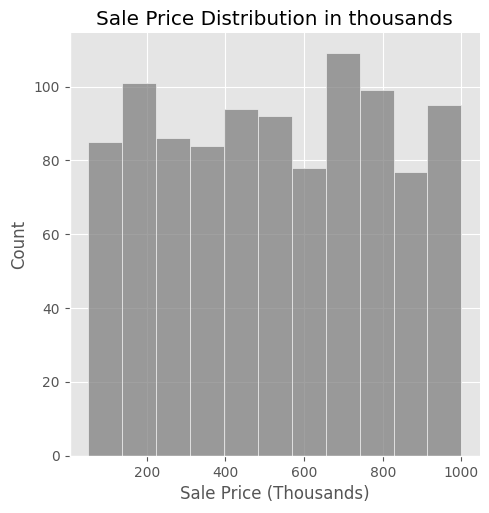

In [1192]:
plt.figure(figsize=(8, 5))
sns.displot(df['sale_price']/1000, kind='hist', color='gray').set(title='Sale Price Distribution in thousands')
plt.xlabel('Sale Price (Thousands)')
plt.show()

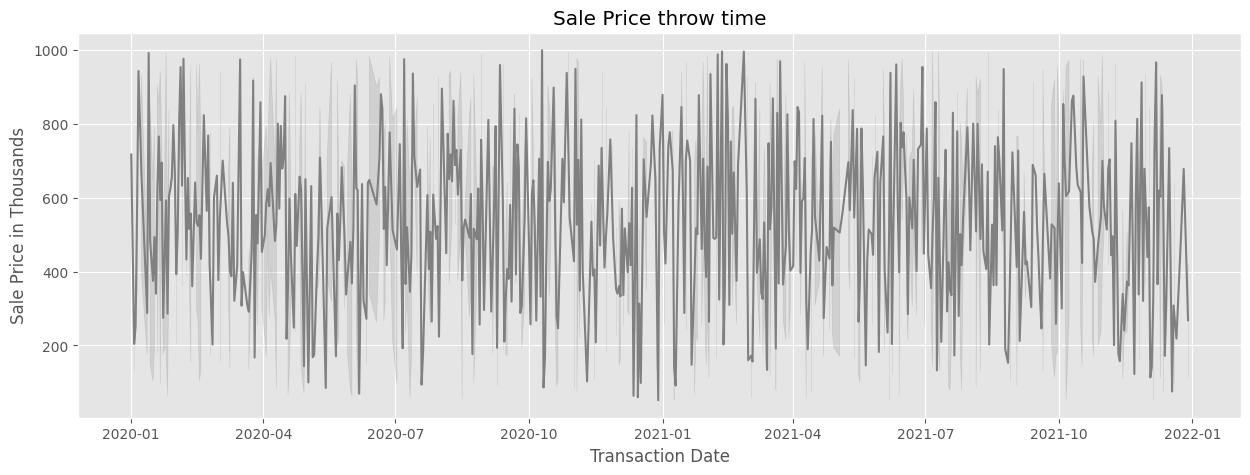

In [1193]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=df['transaction_date'], y=df['sale_price']/1000, color='gray').set(title='Sale Price throw time')
plt.xlabel('Transaction Date')
plt.ylabel('Sale Price in Thousands')
plt.show()

AdFuller test p-value for stationarity: 0.0


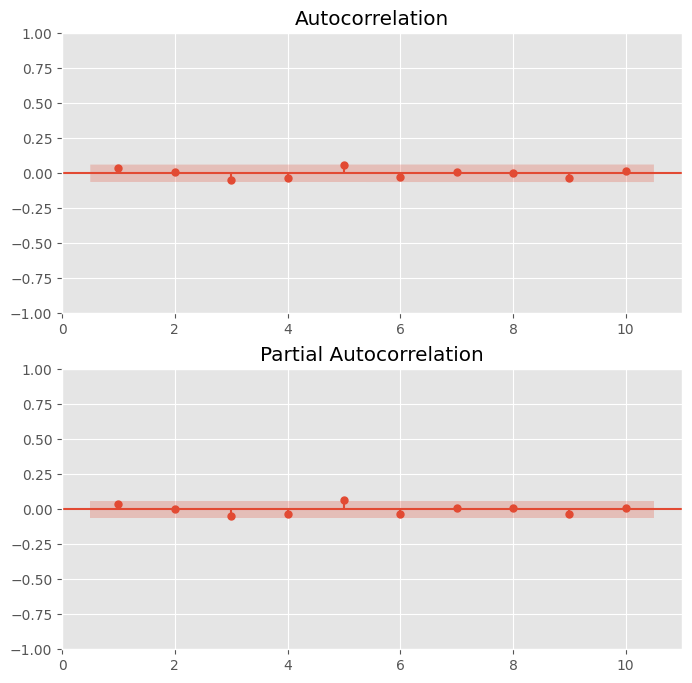

In [1194]:
results = adfuller(df['sale_price'])
print(f'AdFuller test p-value for stationarity: {results[1]}')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
plot_acf(df['sale_price'], lags=10, zero=False, ax=ax1)
plot_pacf(df['sale_price'], lags=10, zero=False, ax=ax2)
plt.show()

#### Exploring the categorical features
##### Overview
- Categorical columns appears to give some information about sale price. But it is too weak. None of the categorical features show strong predictive power on their own.

##### Property Type analysis 
- The mean price for each property type are very close. A slight difference for 'condo', which has lower price than the other property types.

##### Neighborhood  
- The mean price for each neighborhood is also very close. Rural neighborhood has lower price thant the other property types.

##### Bedrooms and Bathrooms
- No significative difference when the number of bedrooms and bathrooms increase.

##### Garage Spaces
- Properties with 1 to 2 garages have slightly higher average sale prices. However, the differences are small.

##### Has Pool
- Properties without a pool have a higher mean price. This can be because the presence of a pool increases the maintenance costs.

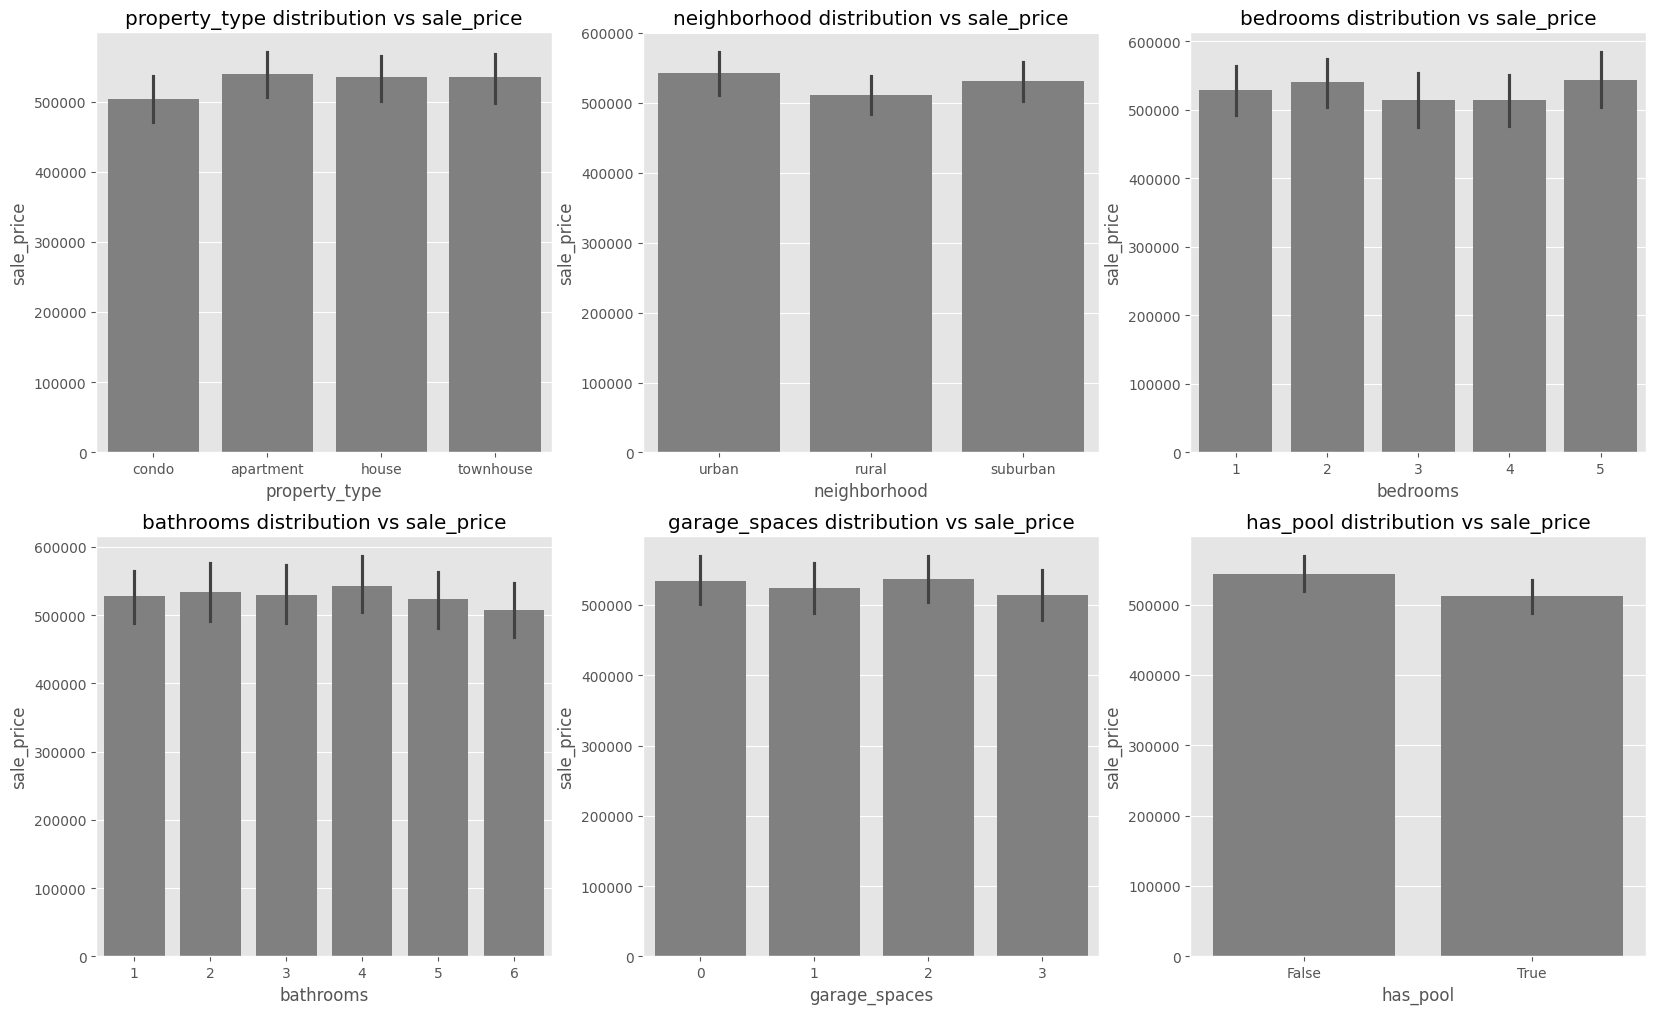

In [1195]:
cat_columns = df.select_dtypes('object').columns.to_list() + ['bedrooms', 'bathrooms', 'garage_spaces', 'has_pool']
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
for i in range(len(cat_columns)):
    sns.barplot(x=cat_columns[i], y='sale_price', data=df, color='gray', ax=axes[i//3, i%3]).set(title=f'{cat_columns[i]} distribution vs sale_price')
plt.show()

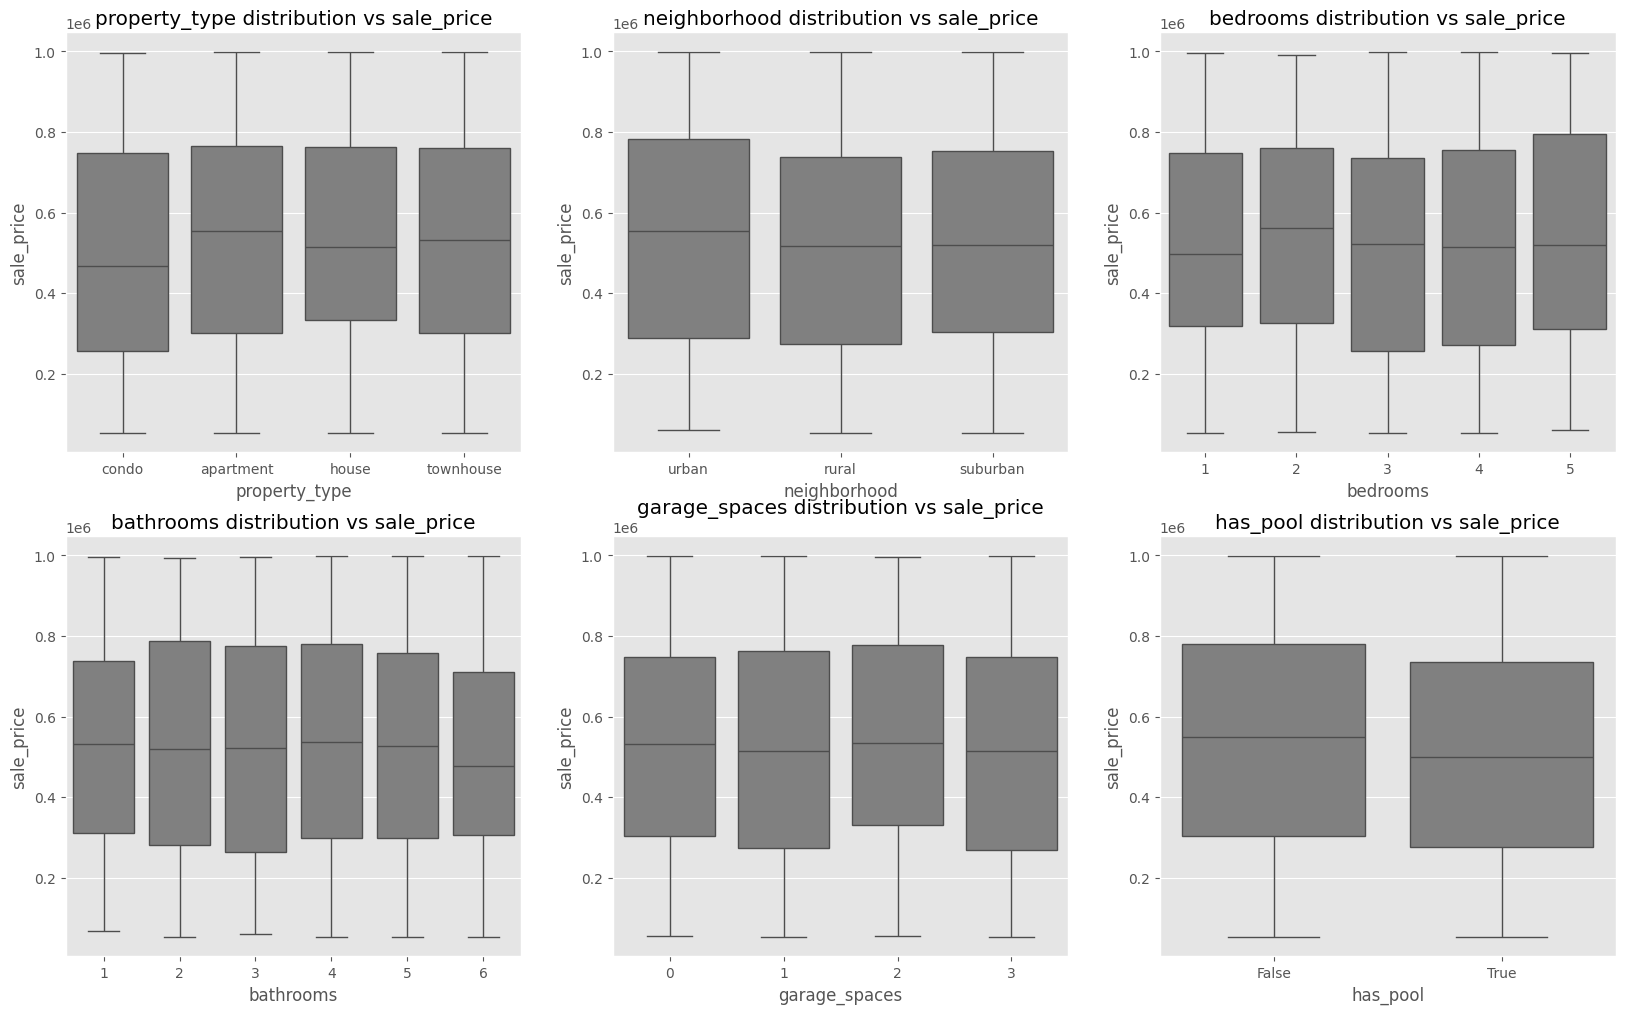

In [1196]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
for i in range(len(cat_columns)):
    sns.boxplot(x=cat_columns[i], y='sale_price', data=df, color='gray', ax=axes[i//3, i%3]).set(title=f'{cat_columns[i]} distribution vs sale_price')
plt.show()

#### Exploring the numerical features
##### Overview
- None of the numerical features showed a relationship with the sale price. We can see that the data points are too disperse and there is no correlation between the features in the heatmap.

In [1197]:
from sklearn.preprocessing import StandardScaler
num_columns = df.drop(cat_columns, axis=1).drop('sale_price', axis=1).drop('transaction_date', axis=1).columns

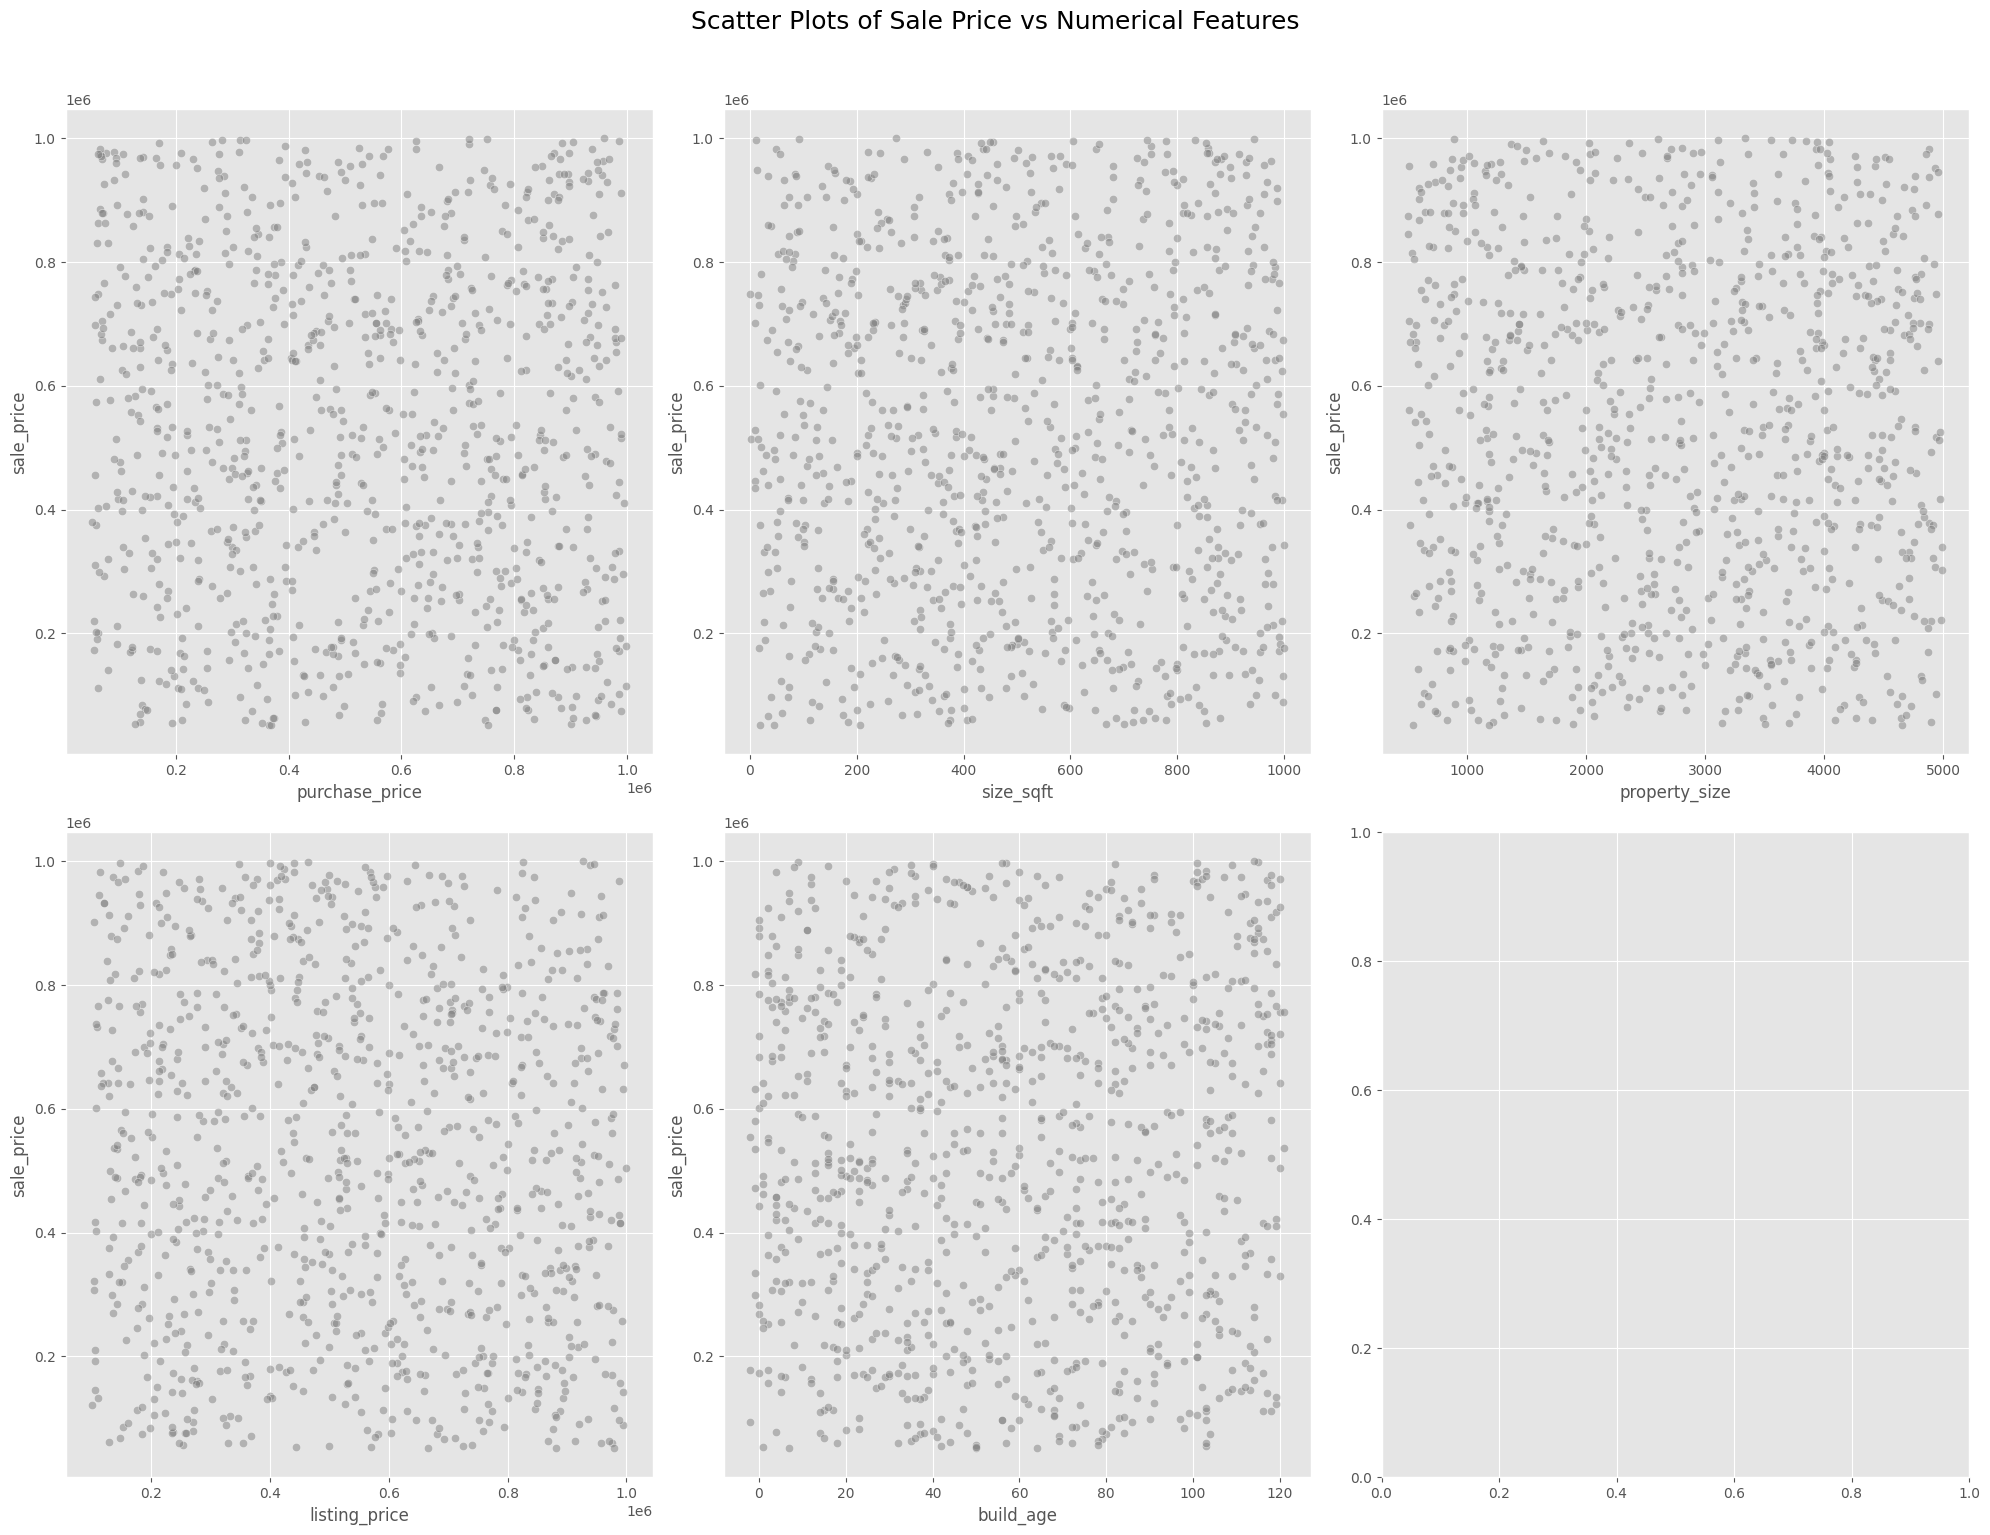

In [1198]:
fig, axes = plt.subplots(len(num_columns)//3+1, 3, figsize=(20, 15))
for i in range(len(num_columns)):
    sns.scatterplot(x=num_columns[i], y='sale_price', data=df, color='gray', ax=axes[i//3, i%3], alpha=.5)
fig.suptitle('Scatter Plots of Sale Price vs Numerical Features', fontsize=18, y=1.02)     
plt.tight_layout() 
plt.show()

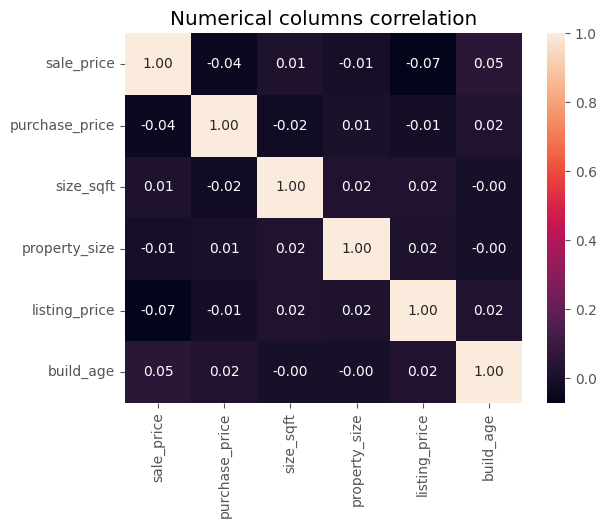

In [1199]:
sns.heatmap(df[['sale_price'] + num_columns.to_list()].corr(), annot=True, fmt=".2f").set(title='Numerical columns correlation')
plt.show()

In [1200]:
df.set_index('transaction_date', inplace=True)
df = df.sort_index(ascending=True)
df.head(5)

,property_type,sale_price,purchase_price,size_sqft,bedrooms,bathrooms,property_size,listing_price,neighborhood,garage_spaces,has_pool,build_age
transaction_date,,,,,,,,,,,,
2020-01-01,townhouse,717115.33,930431.23,485,3,1,1281,971750.32,suburban,3,True,0
2020-01-03,house,275817.11,264079.72,433,3,5,677,683836.48,urban,3,True,92
2020-01-03,townhouse,132570.96,721419.75,268,3,2,1492,110834.74,suburban,1,False,36
2020-01-04,apartment,252792.66,670244.76,466,4,1,3679,797546.08,suburban,0,False,19
2020-01-05,condo,781097.15,363666.59,981,4,6,4810,857518.45,suburban,3,False,13


#### Model fit and evaluation
Since the target variable is numerical, we are dealing with a regression problem. First, we will use K Neighborhood Regression as a baseline linear model. Then, we will introduce a Random Forest Regressor for it's complexity and compare the results.

Given that the dataset has a time series aspect, I didn't shuffle the split. I'll use R2-Score and RMSE (Root Mean Squared Error) to measure how well the model predicts sale price.

##### Preparing data for modelling
To prepare the data for modelling, I made the following steps:
- Transform categorical features to numerical using one hot encoder.
- Transform numerical features to equalize scale using Min Max Transformer.
- Split the data into train set and a test set whitout suffle to preserve the temporarity.

In [1201]:
X = df.drop(columns='sale_price')
y = df['sale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1, shuffle=False)

In [1202]:
numerical_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cat_columns),
    ('num', numerical_transformer, num_columns)
], remainder='passthrough')

pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsRegressor())
])

pipeline_knn.fit(X_train, y_train)
y_knn = pipeline_knn.predict(X_test)
r2 = r2_score(y_test, y_knn)
rmse = root_mean_squared_error(y_test, y_knn)
print('K Neighbors Regressor R2-Score: ', r2)
print('K Neighbors Regressor Mean Squared Error: ', rmse)
print(f'First five predictions: {y_knn[:5]}')

K Neighbors Regressor R2-Score:  -0.194967874068964
K Neighbors Regressor Mean Squared Error:  302100.1690630997
First five predictions: [443041.102 517457.328 687381.052 415222.358 491523.348]


In [1203]:
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cat_columns)
], remainder='passthrough')

pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestRegressor())
])

pipeline_rf.fit(X_train, y_train)
y_rf = pipeline_rf.predict(X_test)
r2 = r2_score(y_test, y_rf)
rmse = root_mean_squared_error(y_test, y_rf)
print('Random Forest Regression R2-Score: ', r2)
print('Random Forest Regression Mean Squared Error: ', rmse)
print(f'First five predictions: {y_rf[:5]}')

Random Forest Regression R2-Score:  -0.05500305269758887
Random Forest Regression Mean Squared Error:  283857.06736857485
First five predictions: [561169.551  420877.066  509817.9951 554528.66   489028.7498]


In [1204]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': np.arange(1, 21, 5),
}
model = GridSearchCV(RandomForestRegressor(random_state=1), param_grid, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cat_columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline.fit(X_train, y_train)
y_rf = pipeline.predict(X_test)
r2 = r2_score(y_test, y_rf)
rmse = root_mean_squared_error(y_test, y_rf)
print('Hyper Parameter Tunned Random Forest Regression R2-Score: ', r2)
print('Hyper Parameter Tunned Random Forest Regression Mean Squared Error: ', rmse)
print(f'First five predictions: {y_rf[:5]}')

Hyper Parameter Tunned Random Forest Regression R2-Score:  -0.0006571628419180797
Hyper Parameter Tunned Random Forest Regression Mean Squared Error:  276449.3083335791
First five predictions: [528546.73260051 504235.24246947 522538.93480754 523504.11493253
 516069.49404544]


g:\Meu Drive\Codigos\aMORA\test\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


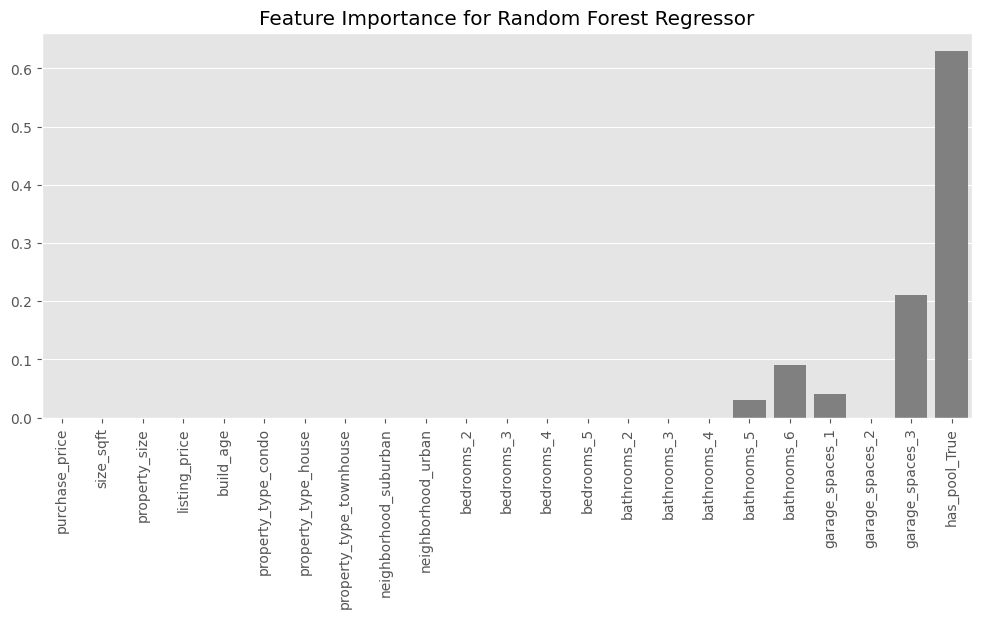

In [1205]:
onehot_feature_names = pipeline_rf.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(cat_columns)
feature_names = np.concatenate([num_columns, onehot_feature_names])
feature_importance = {
    'Feature': feature_names,
    'Importance':pipeline.named_steps['classifier'].best_estimator_.feature_importances_
}
plt.figure(figsize=(12, 5))
sns.barplot(x=feature_importance['Feature'], y=feature_importance['Importance'], color='gray')\
    .set(title='Feature Importance for Random Forest Regressor')
plt.xticks(rotation=90)
plt.show()

##### Results
The K Neighbors Regressor has a lower R² score and a higher MSE compared to the Random Forest Regressor. This means that the Random Forest model, performs better in predicting the target variable.

The negative R² scores from both models **indicate that neither model predict well the target variable**. Both models perform worse than simply predicting the mean value of the target variable.

The high MSE values for both models shows that the predictions deviate significantly from the actual values, this ilustrate a lack of predictive power and the need for better features.

We can see by the feature importances that it is in line with our Exploratory Analysis. The majority of features don't have predictive power, and has_pool has the most predictive power.

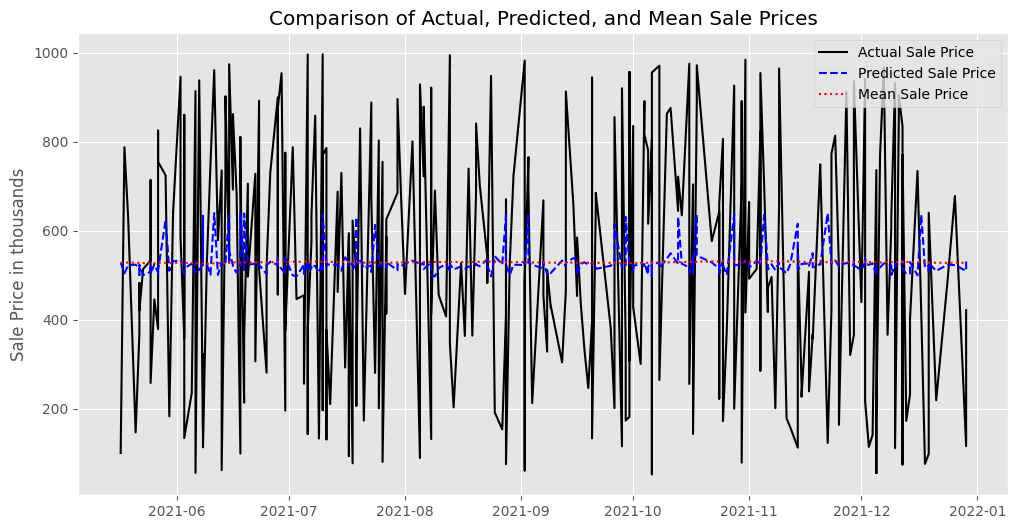

In [1206]:
mean = df['sale_price'].expanding().mean().dropna()
mean = mean.loc[y_test.index].drop_duplicates()[2:]
results = pd.DataFrame({'sale_price':y_test,
              'sale_price_predict': y_rf,
              'mean_price': mean})
results = results/1000

plt.figure(figsize=(12, 6))
plt.plot(results['sale_price'], label='Actual Sale Price', color='black')
plt.plot(results['sale_price_predict'], label='Predicted Sale Price', linestyle='--', color='blue')
plt.plot(results['mean_price'], label='Mean Sale Price', linestyle=':', color='red')
plt.legend()
plt.title('Comparison of Actual, Predicted, and Mean Sale Prices')
plt.ylabel('Sale Price in thousands')
plt.show()

##### Recommendation
I recommend to look for more predictive features. This model can't capture the sale price effectively. Since I found some errors in the datasets, like bathroms in irrational format. I suggest to explore the step of data collection and look for some issues. I also recommend to put a timestamp column in economics dataset, so we can have more features to look for patterns.

This model can be replaced by a simple mean of the past prices.

##### API model
I will create an API with only the most import features, making the user input less data.
In the next steps I'll:
- Develop the slim model
- Save a train dataset for future updates
- Output the model so the API can read it

In [1207]:
important_features = ['bathrooms', 'has_pool', 'garage_spaces']

X = df[important_features]
y = df['sale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=None, random_state=1, shuffle=False)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': np.arange(1, 21, 5),
}
model = GridSearchCV(RandomForestRegressor(random_state=1), param_grid, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, important_features)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline.fit(X_train, y_train)
y_rf = pipeline.predict(X_train)
r2 = r2_score(y_train, y_rf)
rmse = root_mean_squared_error(y_train, y_rf)
print('Hyper Parameter Tunned Random Forest Regression R2-Score: ', r2)
print('Hyper Parameter Tunned Random Forest Regression Mean Squared Error: ', rmse)
print(f'First five predictions: {y_rf[:5]}')

Hyper Parameter Tunned Random Forest Regression R2-Score:  0.006673244069401063
Hyper Parameter Tunned Random Forest Regression Mean Squared Error:  271969.0847366353
First five predictions: [509650.06602005 508808.67789365 535061.6030317  540680.79430047
 539044.36988757]


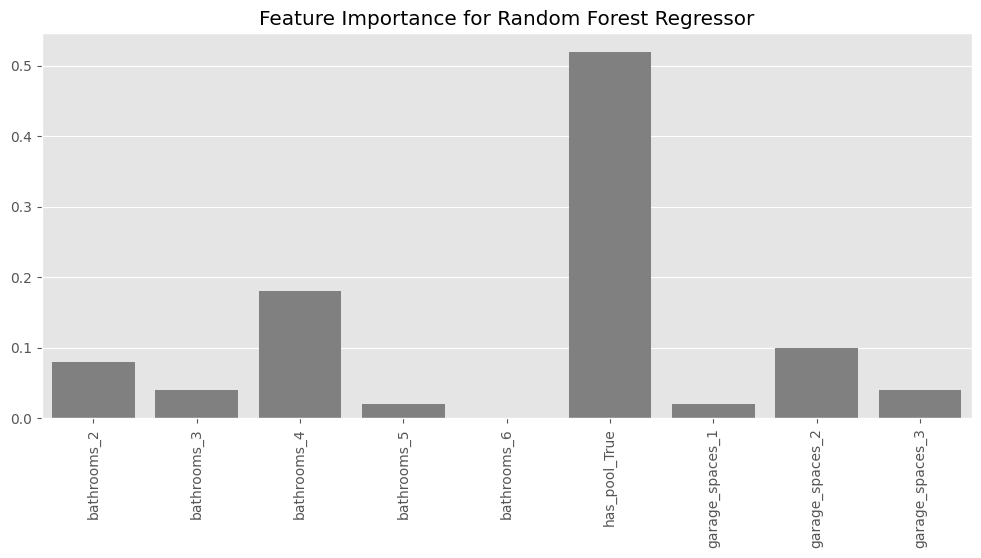

In [1208]:
onehot_feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(important_features)
feature_importance = {
    'Feature': onehot_feature_names,
    'Importance':pipeline.named_steps['classifier'].best_estimator_.feature_importances_
}
plt.figure(figsize=(12, 5))
sns.barplot(x=feature_importance['Feature'], y=feature_importance['Importance'], color='gray')\
    .set(title='Feature Importance for Random Forest Regressor')
plt.xticks(rotation=90)
plt.show()

In [1209]:
'''
import joblib
df[important_features + ['sale_price']].to_csv('./API/train_data.csv', index=False)
joblib.dump(pipeline, '.\API\model.joblib')
'''

"\nimport joblib\ndf[important_features + ['sale_price']].to_csv('./API/train_data.csv', index=False)\njoblib.dump(pipeline, '.\\API\\model.joblib')\n"